## Tutorial on Normalizing Flows

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity


In [2]:
## Function definitions
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

### What is a Normalizing Flow and why it is useful?

A major goal of statistics and Machine Learning has been to model a probability distribution given samples drawn from that distribution. A typical approach to learn a pdf from samples is Kernel Desnity Estimation (KDE). Let's see an example of KDE

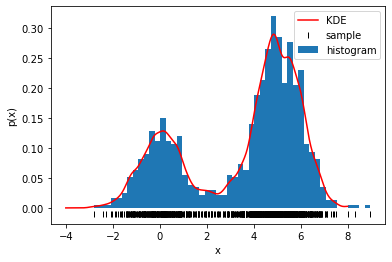

In [3]:
#Generate samples
N = 1000
x = make_data(N)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(x[:, None])

x_d = np.linspace(-4, 8, N)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

#Plot histogram
plt.hist(x, bins=50, density=True)
plt.plot(x_d, np.exp(logprob),'r')
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(['KDE', 'sample','histogram'])

The KDE approximation is given by the following expression: 



where K is the kernel function (Gaussian kernel in the above example).

### Maximizing the probability of the data

To approximate a probability density function $p(\mathbf{x})$ from a set of N samples drawn from it, we can propose a parametrized function that is close to the true pdf $p_{\theta}(\mathbf{D}) = p_{\theta}(\mathbf{x}^{(1)}, \mathbf{x}^{(2)},...,\mathbf{x}^{(N)}) \approx p(\mathbf{x})$ where the training sample set is $\mathbf{D} = \{\mathbf{x}^{(i)}\}_{i=1}^{N}$ and each sample comes from the true, unknown distribution $\mathbf{x}^{(i)} \sim p(\mathbf{x})$. Assuming that the samples are independent from each other, we have

$$p_{\theta}(\mathbf{D}) = p_{\theta}(\mathbf{x}^{(1)}, \mathbf{x}^{(2)},...,\mathbf{x}^{(N)}) = \prod_{i=1}^{N}p_{\theta}(\mathbf{x}^{(i)})$$

Next, we want to find the parameters $\theta$ that maximize $p_{\theta}(\mathbf{D})$

$$ \theta^* = \text{argmax}_{\theta}\,\, p_{\theta}(\mathbf{D}) = \text{argmax}_{\theta}\,\, \text{log} \big(p_{\theta}(\mathbf{D}) \big) =  \text{argmax}_{\theta}\,\, \sum_{i = 1}^{N} \text{log} \bigg(p_{\theta}(\mathbf{x}^{(i)})\bigg)$$

where the second equality comes from the fact that taking the logarithm of a function does not change the maximizer $\theta^*$ since the logarithm is a monotonic function.

### Example

In [4]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from scipy.stats import multivariate_normal
np.random.seed(10)


class Gaussian():
    '''
    class for multivariate gaussian distribution
    '''
    def __init__(self, mu=0, sigma=0):
        self.mu = np.atleast_1d(mu)              #turns a scalar into 1D array otherwise preserves the arrray
        if np.array(sigma).ndim == 0:             #when sigma is scalar
            self.Sigma = np.atleast_2d(sigma**2)  #turns a scalar into 2D array otherwise preserves the arrray
        else:
            self.Sigma = sigma

    def density(self, x):
        n,d = x.shape
        xm = (x-self.mu[None,:])                                                    
        normalization = ((2*np.pi)**(-d/2.)) * np.linalg.det(self.Sigma)**(-1/2.)
        quadratic = np.sum((xm @ np.linalg.inv(self.Sigma)) * xm, axis=1)          #Note the @ sign here denotes matrix multiplication
        return normalization * np.exp(-.5 *  quadratic)

def plot_density(mu, Sigma, ax=None):                                 #only for 2D case
    r1 = mu[0]-2*np.sqrt(Sigma[0,0]), mu[0]+2*np.sqrt(Sigma[0,0])     #get the range of x axis in the grid
    r2 = mu[1]-2*np.sqrt(Sigma[1,1]), mu[1]+2*np.sqrt(Sigma[1,1])     #get the range of y axis in the grid
    x1, x2 = np.mgrid[r1[0]:r1[1]:.01, r2[0]:r2[1]:.01]               #get the meshgrid       
    x = np.vstack((x1.ravel(), x2.ravel())).T         #flatten it
    if not ax:
        ax = plt.gca()                                #if no axes is passed get the current Axes instance on the current figure
    p = Gaussian(mu,Sigma).density(x)                 #get the probability density values over the grid 
    #ax.set_aspect(1)
    ax.set_xlim(*r1)
    ax.set_ylim(*r2)
    ax.contour(x1, x2, p.reshape(x1.shape))           #plot the contours
    ax.set_xlabel(r"$x_1$", fontsize = 16)
    ax.set_ylabel(r"$x_2$", fontsize = 16)
    return ax

def compute_logprob(pdf, data):
    
    N = data.shape[0]
    log_prob = 0
    
    for i in range(N):
        pdi = pdf.pdf(data[i,:])
        log_prob =+ np.log(pdi)
    
    return log_prob


### True probability density
true_mean = [0.5, -0.2]
true_cov = [[2.0, 0.3], [0.3, 0.5]]
true_pdf = multivariate_normal(true_mean, true_cov)


data = np.random.multivariate_normal(true_mean, true_cov, size=10000)


mean_list = [true_mean, [2, 1], [-1,0],[0,0]]
cov_list = [true_cov, [[1.,0],[0,1]],
             [[3,1.],[1.,2.]], [[2,-0.5],[-0.5,1]]]
pdf_list = []
for i in range(len(mean_list)):
    mean = mean_list[i]
    cov = cov_list[i]
    pdf_list.append(multivariate_normal(mean, cov))

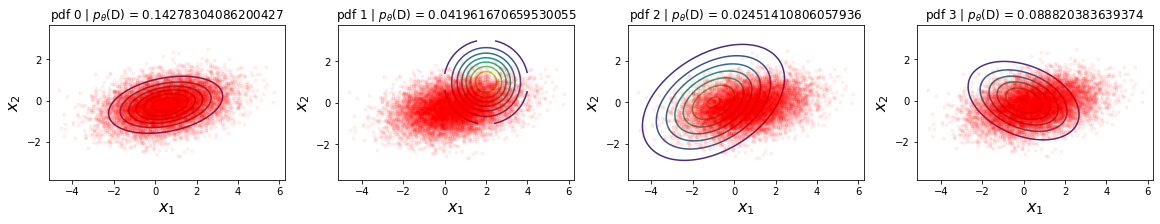

In [5]:
#Take the parameters of two bivariate gaussian distribution
fig, axes = plt.subplots(ncols=len(cov_list), nrows=1, constrained_layout=True, figsize=(16, 3))
for i, pdfi in enumerate(pdf_list):
    mu = mean_list[i]
    cov = cov_list[i]
    log_prob = compute_logprob(pdfi, data)
    ax = plot_density(np.array(mu), np.array(cov), axes[i])
    ax.plot(data[:,0], data[:,1], 'r.', alpha = 0.05)
    ax.axis('equal')
    ax.set_title(r'pdf {} | $p_\theta$(D) = {}'.format(i,np.exp(log_prob)))
    
plt.show()

Normalizing flows (NF) are a family of **generative models** with tractable distributions where both **sampling** and **density evaluation** can be efficient and exact. A NF transforms a **simple pdf** into a more **complex pdf** by a sequanceof **invertble and differentiable mappings**.

<img src="comparison_GAN_VAE_NF.png" alt="drawing" width="600"/>

Let's denote $\mathbf{X} \in \mathcal{X} \subset R^D$ and $\mathbf{Z} \in \mathcal{Z} \subset R^D$ as random variables coming from a target $\mathbf{X} \sim p_\mathbf{X}$ and base $\mathbf{Z} \sim p_\mathbf{Z}$ distributions and that there is an invertible and differentiable mapping $\mathbf{g}:R^D \rightarrow R^D$ such that $\mathbf{X} = \mathbf{g}(\mathbf{Z})$ and $\mathbf{Z} = \mathbf{g}^{-1}(\mathbf{X}) = \mathbf{f}(\mathbf{X})$.



Using the **change of variables**, the relationship between both pdf is given by 

$$p_\mathbf{X}(\mathbf{x}) = p_\mathbf{Z}(\mathbf{z}) |\text{det}(D\mathbf{f}(\mathbf{x}))|$$

where

$$D\mathbf{f}(\mathbf{x}) = \frac{\partial \mathbf{f}(\mathbf{x})}{\partial \mathbf{x}}$$

<img src="uniform_flow.png" alt="drawing" width="400"/>

One of the most important properties applied to normalizing flows is the fact that the composition of invertible functions is also invertible and the determinant of its jacobian has a specific form. Thus, both $\mathbf{g}(\cdot)$ and $\mathbf{f}(\cdot)$ can be expressed as compositions of simple bijective functions
$$\mathbf{g}(\cdot) = \mathbf{g}_N \circ \mathbf{g}_{N-1}\circ\quad ... \quad\circ \mathbf{g}_1$$
$$\mathbf{f}(\cdot) = \mathbf{f}_1 \circ \mathbf{f}_{2}\circ\quad ... \quad\circ \mathbf{f}_N$$

<img src="normalizing_flow_layout.png" alt="drawing" width="600"/>

and thus, the determinant of the Jacobian is 
$$ \text{det}(D\mathbf{f}(\mathbf{x})) = \prod_{i=1}^{N}\text{det}(D\mathbf{f}_i(\mathbf{x}))$$

Generally, we want to maximize the log-probability of the data, so we have

$$\text{log}(p_\mathbf{X}(\mathbf{x})) = \text{log}(p_\mathbf{Z}(\mathbf{f}(\mathbf{x})) + \text{log}(|\text{det}(D\mathbf{f}(\mathbf{x}))|)$$

and finally applying the flow decomposition we obtain

$$\text{log}(p_\mathbf{X}(\mathbf{x})) = \text{log}(p_\mathbf{Z}(\mathbf{f}(\mathbf{x})) + \sum_{i=1}^{N}\text{log}(\text{det}(D\mathbf{f}_i(\mathbf{x}))) = \text{log}(p_\mathbf{Z}(\mathbf{f}(\mathbf{x})) + \sum_{i=1}^{N}\text{log}(\text{det}(\frac{d \mathbf{z}_i}{d \mathbf{z}_{i-1}}))$$

where $$\mathbf{z}_0 = \mathbf{x}$$ and $$\mathbf{z}_i = \mathbf{f}_i(\mathbf{z}_{i-1})$$

## Methods

Normalizing flows must satisfy some conditions to be practical:

1) Be invertible; for sampling we need $\mathbf{g}$ while for evaluating likelihood we need $\mathbf{f}$

2) Be sufficiently expressive to approximate complex distributions

3) Be computationally efficient to compute $\mathbf{g}$ and $\mathbf{f}$ and the determinant of the Jacobian

### What type of elementary flows that satisfy the above conditions can form $\mathbf{g}_i,\,\, i = 1,...,N$?

The following list is a summary of valid elementary flows:

#### 1) Elementwise flows (e.g. invertible activation functions in DNNs)

$$ \mathbf{g}(\mathbf{z}) = [h(z_1), h(z_2), ..., h(z_D)]^T $$

Example: Leaky ReLU function

\begin{equation}
h(z) = \begin{cases}
  z  & \text{if}\quad z > 0 \\
  \alpha z & \text{if}\quad z <= 0
\end{cases}
\end{equation}

\begin{equation}
h^{-1}(y) = \begin{cases}
  y  & \text{if}\quad y > 0 \\
  \frac{y}{\alpha} & \text{if}\quad y <= 0
\end{cases}
\end{equation}

Problem: elementwise flows cannot express correlation between variables

#### 2) Linear flows

$$ \mathbf{g}(\mathbf{z}) = \mathbf{A}\mathbf{z} + \mathbf{b}$$

Advantage: the determinant of the Jacobian $det(D\mathbf{g}(\mathbf{z}))$ is simply $det(\mathbf{A})$.

Disadvantage: linear flows are limited in their expressiveness. For example, if $p_{\mathbf{Z}} \sim \mathcal{N}(\mathbf{z}; \mu, \Sigma)$ then $p_{\mathbf{Y}} \sim \mathcal{N}(\mathbf{y}; \mathbf{A}\mu + \mathbf{b}, \mathbf{A}^T\Sigma\mathbf{A})$.

#### 3) Planar and radial flows


#### 4) Coupling and autoregressive flows


#### 5) Residual flows


### Example - Real Non-Volume Preserving Flows (RNVP)


In this case, we consider an RNVP invertible function $$\mathbf{f}: R^d \rightarrow R^d$$ given by

$\mathbf{z} = \mathbf{f}(\mathbf{x}) = \begin{bmatrix} \mathbf{f}_{1:k} \\ \mathbf{f}_{k+1:d} \end{bmatrix} = \begin{bmatrix} \mathbf{x}_{1:k} \\ \mathbf{x}_{k+1:d}\text{exp}(\sigma(\mathbf{x}_{1:k})) + \mu(\mathbf{x}_{1:k}) \end{bmatrix}$ for any $k \in (0, d]$, where $\sigma(\cdot)$ and $\mu(\cdot)$ are arbitrary functions (e.g. NN)

What is the Jacobian?

$$\frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \begin{bmatrix} \mathbf{I}_d & \mathbf{0} \\ \frac{d \mathbf{z}_{k+1:d}}{d \mathbf{x}_{1:k}} & \text{diag}(\text{exp}(\sigma(\mathbf{x}_{1:k}))) \end{bmatrix}$$

Hence, $\text{log}(\text{det}(\frac{\partial \mathbf{f}}{\partial \mathbf{x}})) = \sum_{i=1}^{d-k}\sigma_i(\mathbf{x}_{1:k})$

How about $\mathbf{x} = \mathbf{g} = \mathbf{f}^{-1}(\mathbf{z})$?

$\mathbf{x} = \mathbf{g}(\mathbf{z}) = \begin{bmatrix} \mathbf{g}_{1:k} \\ \mathbf{g}_{k+1:d} \end{bmatrix} = \begin{bmatrix} \mathbf{z}_{1:k} \\ \big(\mathbf{z}_{k+1:d} - \mu(\mathbf{z}_{1:k})\big) \text{exp}(-\sigma(\mathbf{z}_{1:k}))\end{bmatrix}$ 


The optimization problem becomes

$$\mathbf{\theta}^* = \text{argmax}_{\theta} \quad \text{log}(p_\mathbf{X}(\mathbf{x})) = \text{argmax}_{\theta}\quad \text{log}(p_\mathbf{Z}(\mathbf{f}_{\theta}(\mathbf{x})) + \sum_{i=1}^{N}\text{log}(\text{det}(\frac{d \mathbf{z}_{\theta,i}}{d \mathbf{z}_{\theta,i-1}}))$$


#### Sample generation

$$\mathbf{z} \sim p_\mathbf{Z}(\mathbf{z})$$

$$\mathbf{x}_{\text{gen}} = \mathbf{f}^{-1}(\mathbf{z})$$

### Practical example

Text(0.5, 1.0, 'Input data')

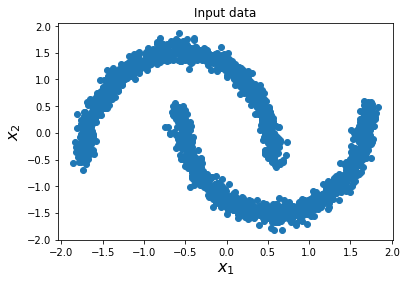

In [6]:
from __future__ import division

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
# normalize
X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title('Input data')

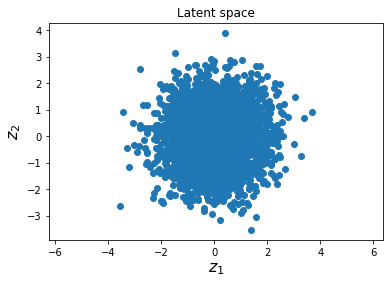

In [7]:
import torch
import torch.nn as nn 
from math import pi 

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal

base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(3000,))
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel(r'$z_1$', fontsize = 16)
plt.ylabel(r'$z_2$', fontsize = 16)
plt.title('Latent space')
plt.axis('equal')
plt.show()


class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [8]:
class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
def train(model, epochs, batch_size, optim, scheduler):
    losses = []
    for epoch in range(epochs):

        # get batch 
        X, _ = datasets.make_moons(n_samples=batch_size, noise=.05)
        X = torch.from_numpy(StandardScaler().fit_transform(X)).float()

        optim.zero_grad()
        z, log_pz, log_jacob = model(X)
        loss = (-log_pz - log_jacob).mean()
        losses.append(loss)

        loss.backward()
        optim.step()
        scheduler.step()
        
        print(f'Epoch: {epoch} | Loss: {loss}')
        
    return losses

def view(model, losses):
    losses = [loss.detach().numpy() for loss in losses]
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    X_hat = model.inverse(Z).detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1])
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.show()

    n_samples = 10000
    X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
    X = torch.from_numpy(StandardScaler().fit_transform(X)).float()
    z, _, _ = model(X)
    z = z.detach().numpy()
    plt.scatter(z[:, 0], z[:, 1])
    plt.title("Transformation of Data Samples X: Z = F(X)")
    plt.show()

In [9]:
d = 2
k = 1


model = stacked_NVP(d, k, hidden=512, n=8)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)

Epoch: 0 | Loss: 4.019235134124756
Epoch: 1 | Loss: 3.76658034324646
Epoch: 2 | Loss: 3.550987482070923
Epoch: 3 | Loss: 3.3810489177703857
Epoch: 4 | Loss: 3.2515416145324707
Epoch: 5 | Loss: 3.1372854709625244
Epoch: 6 | Loss: 3.0329947471618652
Epoch: 7 | Loss: 2.966060161590576
Epoch: 8 | Loss: 2.897688388824463
Epoch: 9 | Loss: 2.846125364303589
Epoch: 10 | Loss: 2.8010637760162354
Epoch: 11 | Loss: 2.7706515789031982
Epoch: 12 | Loss: 2.7411506175994873
Epoch: 13 | Loss: 2.726444721221924
Epoch: 14 | Loss: 2.7123780250549316
Epoch: 15 | Loss: 2.7127509117126465
Epoch: 16 | Loss: 2.7023675441741943
Epoch: 17 | Loss: 2.695019245147705
Epoch: 18 | Loss: 2.6932239532470703
Epoch: 19 | Loss: 2.692089080810547
Epoch: 20 | Loss: 2.699298858642578
Epoch: 21 | Loss: 2.693542003631592
Epoch: 22 | Loss: 2.6925506591796875
Epoch: 23 | Loss: 2.6838364601135254
Epoch: 24 | Loss: 2.676783561706543
Epoch: 25 | Loss: 2.6695749759674072
Epoch: 26 | Loss: 2.658912181854248
Epoch: 27 | Loss: 2.64573

Epoch: 223 | Loss: 2.0058722496032715
Epoch: 224 | Loss: 1.9919962882995605
Epoch: 225 | Loss: 2.0088279247283936
Epoch: 226 | Loss: 1.986079454421997
Epoch: 227 | Loss: 1.9779515266418457
Epoch: 228 | Loss: 1.9926471710205078
Epoch: 229 | Loss: 2.0355186462402344
Epoch: 230 | Loss: 1.9776579141616821
Epoch: 231 | Loss: 1.988353967666626
Epoch: 232 | Loss: 1.9868462085723877
Epoch: 233 | Loss: 2.01305890083313
Epoch: 234 | Loss: 2.000432252883911
Epoch: 235 | Loss: 2.0167274475097656
Epoch: 236 | Loss: 1.9805774688720703
Epoch: 237 | Loss: 2.007704019546509
Epoch: 238 | Loss: 1.976151943206787
Epoch: 239 | Loss: 1.9854100942611694
Epoch: 240 | Loss: 2.007978677749634
Epoch: 241 | Loss: 1.9678677320480347
Epoch: 242 | Loss: 2.002239942550659
Epoch: 243 | Loss: 1.9633569717407227
Epoch: 244 | Loss: 1.9880741834640503
Epoch: 245 | Loss: 1.9813508987426758
Epoch: 246 | Loss: 1.990256428718567
Epoch: 247 | Loss: 1.9888226985931396
Epoch: 248 | Loss: 1.9703856706619263
Epoch: 249 | Loss: 2.0

Epoch: 443 | Loss: 1.7338898181915283
Epoch: 444 | Loss: 1.7715588808059692
Epoch: 445 | Loss: 1.748104453086853
Epoch: 446 | Loss: 1.7502068281173706
Epoch: 447 | Loss: 1.7636094093322754
Epoch: 448 | Loss: 1.7456685304641724
Epoch: 449 | Loss: 1.7513822317123413
Epoch: 450 | Loss: 1.7725051641464233
Epoch: 451 | Loss: 1.7265429496765137
Epoch: 452 | Loss: 1.7604037523269653
Epoch: 453 | Loss: 1.7009588479995728
Epoch: 454 | Loss: 1.6800365447998047
Epoch: 455 | Loss: 1.7200419902801514
Epoch: 456 | Loss: 1.7217851877212524
Epoch: 457 | Loss: 1.6875590085983276
Epoch: 458 | Loss: 1.7118836641311646
Epoch: 459 | Loss: 1.6823749542236328
Epoch: 460 | Loss: 1.707489252090454
Epoch: 461 | Loss: 1.7138124704360962
Epoch: 462 | Loss: 1.7204334735870361
Epoch: 463 | Loss: 1.681074619293213
Epoch: 464 | Loss: 1.6817004680633545
Epoch: 465 | Loss: 1.7034939527511597
Epoch: 466 | Loss: 1.7325844764709473
Epoch: 467 | Loss: 1.7123321294784546
Epoch: 468 | Loss: 1.7784786224365234
Epoch: 469 | Lo

Epoch: 660 | Loss: 1.5082921981811523
Epoch: 661 | Loss: 1.479608178138733
Epoch: 662 | Loss: 1.4641185998916626
Epoch: 663 | Loss: 1.5310596227645874
Epoch: 664 | Loss: 1.4443745613098145
Epoch: 665 | Loss: 1.4737900495529175
Epoch: 666 | Loss: 1.4926116466522217
Epoch: 667 | Loss: 1.454540491104126
Epoch: 668 | Loss: 1.4343796968460083
Epoch: 669 | Loss: 1.5078730583190918
Epoch: 670 | Loss: 1.4737030267715454
Epoch: 671 | Loss: 1.4717342853546143
Epoch: 672 | Loss: 1.5000590085983276
Epoch: 673 | Loss: 1.4409986734390259
Epoch: 674 | Loss: 1.494774341583252
Epoch: 675 | Loss: 1.501569390296936
Epoch: 676 | Loss: 1.4863121509552002
Epoch: 677 | Loss: 1.4800523519515991
Epoch: 678 | Loss: 1.5097960233688354
Epoch: 679 | Loss: 1.488576054573059
Epoch: 680 | Loss: 1.4548063278198242
Epoch: 681 | Loss: 1.4179527759552002
Epoch: 682 | Loss: 1.4314109086990356
Epoch: 683 | Loss: 1.462101697921753
Epoch: 684 | Loss: 1.4462249279022217
Epoch: 685 | Loss: 1.4885510206222534
Epoch: 686 | Loss:

Epoch: 880 | Loss: 1.3270823955535889
Epoch: 881 | Loss: 1.3309102058410645
Epoch: 882 | Loss: 1.4062516689300537
Epoch: 883 | Loss: 1.467198133468628
Epoch: 884 | Loss: 1.3991175889968872
Epoch: 885 | Loss: 1.3160467147827148
Epoch: 886 | Loss: 1.3389860391616821
Epoch: 887 | Loss: 1.3539812564849854
Epoch: 888 | Loss: 1.3589413166046143
Epoch: 889 | Loss: 1.3630746603012085
Epoch: 890 | Loss: 1.3903433084487915
Epoch: 891 | Loss: 1.3957045078277588
Epoch: 892 | Loss: 1.3457536697387695
Epoch: 893 | Loss: 1.327491283416748
Epoch: 894 | Loss: 1.4259573221206665
Epoch: 895 | Loss: 1.3753496408462524
Epoch: 896 | Loss: 1.3532450199127197
Epoch: 897 | Loss: 1.3337147235870361
Epoch: 898 | Loss: 1.33592689037323
Epoch: 899 | Loss: 1.4661030769348145
Epoch: 900 | Loss: 1.3565309047698975
Epoch: 901 | Loss: 1.343746542930603
Epoch: 902 | Loss: 1.4222593307495117
Epoch: 903 | Loss: 1.3967647552490234
Epoch: 904 | Loss: 1.3549606800079346
Epoch: 905 | Loss: 1.3461495637893677
Epoch: 906 | Loss

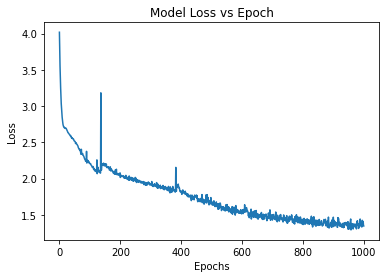

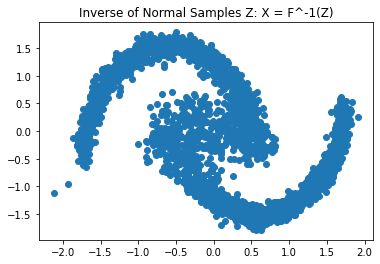

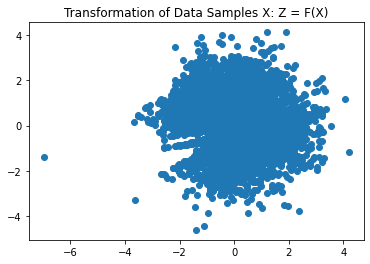

In [10]:
view(model, losses)